<a href="https://colab.research.google.com/github/galihpermana29/voice-stress-detection-mfcc-spectral-centroid/blob/main/SKRIPSI_GALIH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!sudo apt-get update
!sudo apt-get install -y libsndfile1 -y
!pip install --upgrade pip
!sudo apt-get install portaudio19-dev -y

!pip install librosa keras tensorflow SpeechRecognition pyaudio ipywebrtc soundfile
!pip install --upgrade librosa

!sudo apt install ffmpeg

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:7 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [47.2 kB]
Get:8 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease [18.1 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,521 kB]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,016 kB]
Get:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Get:13 http://archive.ubuntu.com/

In [2]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from tqdm import tqdm_notebook
import speech_recognition as sr

import soundfile as sf
import shutil

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

# **Data Frame Low**

In [3]:

AudioWAV = "/content/drive/MyDrive/Colab Notebooks/data/WAV2 Low/"
LowDF= "/content/drive/MyDrive/Colab Notebooks/data/WAV Low/data_path_low.csv"
HighDF= "/content/drive/MyDrive/Colab Notebooks/data/WAV High/data_path_high.csv"

audio_directory_list = os.listdir(AudioWAV)

file_emotion = []
file_path = []
for file in audio_directory_list:
    part = file.split('.')[0]
    # part = part.split('-')
    # third part in each file represents the emotion associated to that file.
    file_emotion.append("LowStress")
    file_path.append(AudioWAV + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])


# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Audio_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Audio_df.Emotions.replace({'LowStress'}, inplace=True)
Audio_df.head()


data_path = Audio_df
data_path.to_csv("data_path_low.csv",index=False)
shutil.move("data_path_low.csv", LowDF)

df = pd.read_csv(LowDF)
data_path.head()

,Emotions,Path
0,LowStress,/content/drive/MyDrive/Colab Notebooks/data/WA...
1,LowStress,/content/drive/MyDrive/Colab Notebooks/data/WA...
2,LowStress,/content/drive/MyDrive/Colab Notebooks/data/WA...
3,LowStress,/content/drive/MyDrive/Colab Notebooks/data/WA...
4,LowStress,/content/drive/MyDrive/Colab Notebooks/data/WA...


# **Data Frame High**

In [4]:
AudioWAV = "/content/drive/MyDrive/Colab Notebooks/data/WAV2 High/"
audio_directory_list = os.listdir(AudioWAV)

file_emotion = []
file_path = []
for file in audio_directory_list:
    part = file.split('.')[0]
    # part = part.split('-')
    # third part in each file represents the emotion associated to that file.
    file_emotion.append("HighStress")
    file_path.append(AudioWAV + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])


# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Audio_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Audio_df.Emotions.replace({'HighStress'}, inplace=True)
Audio_df.head()


data_path = Audio_df
data_path.to_csv("data_path_high.csv",index=False)
shutil.move("data_path_high.csv", HighDF)

df = pd.read_csv(HighDF)
data_path.head()

,Emotions,Path
0,HighStress,/content/drive/MyDrive/Colab Notebooks/data/WA...
1,HighStress,/content/drive/MyDrive/Colab Notebooks/data/WA...
2,HighStress,/content/drive/MyDrive/Colab Notebooks/data/WA...
3,HighStress,/content/drive/MyDrive/Colab Notebooks/data/WA...
4,HighStress,/content/drive/MyDrive/Colab Notebooks/data/WA...


Showing dataset calculation

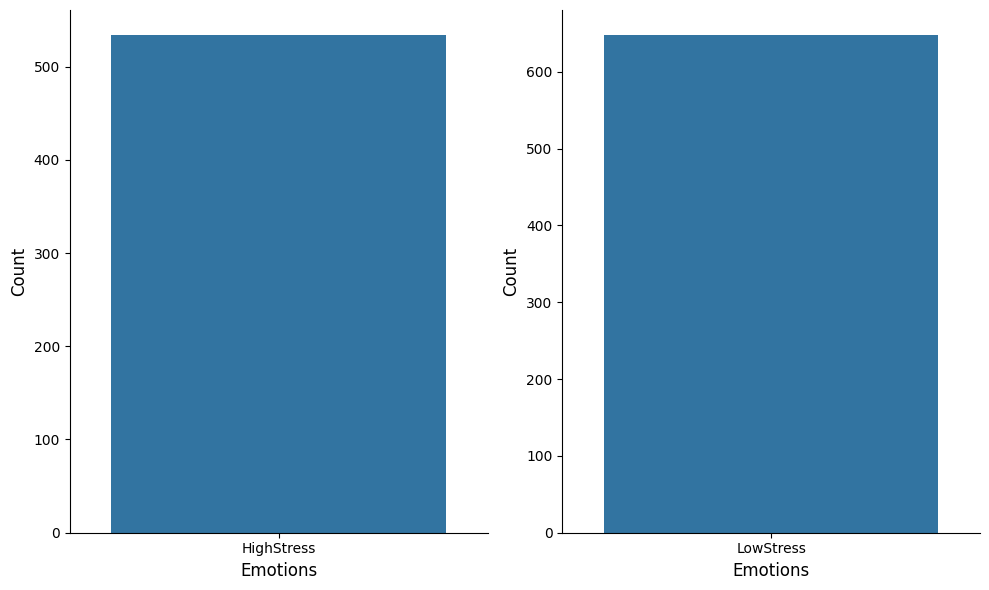

In [5]:
#load from csv
dflow = pd.read_csv(LowDF)
dfhigh = pd.read_csv(HighDF)

# Plotting
plt.figure(1, figsize=(10, 6))  # Adjust the figsize as needed
plt.title('Count of Emotions', size=16)

plt.subplot(1, 2, 1)  # Subplot for dfhigh
sns.countplot(data=dfhigh, x='Emotions')
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)

plt.subplot(1, 2, 2)  # Subplot for dflow
sns.countplot(data=dflow, x='Emotions')
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)

sns.despine(top=True, right=True, left=False, bottom=False)
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

# **MFCC Feature Extraction**

This prepare_data function will execute and prepare data with
- adding offsett/pading
- extract with mfcc
- sr=8000, n_mfcc=40

In [6]:
audio_length=8000 * 1
dim = (60, 1 + int(np.floor(audio_length/512)), 1)

def prepare_data(fnames):
    X = np.empty(shape=(len(fnames), dim[0], dim[1], 1))
    input_length = audio_length
    for i, fname in tqdm_notebook(enumerate(fnames), total=len(fnames)):
        data, _ = librosa.core.load(fname, sr=8000, res_type="kaiser_fast")
        # Random offset / Padding
        if len(data) > input_length:
            max_offset = len(data) - input_length
            offset = np.random.randint(max_offset)
            data = data[offset:(input_length+offset)]
        else:
            if input_length > len(data):
                max_offset = input_length - len(data)
                offset = np.random.randint(max_offset)
            else:
                offset = 0
            data = np.pad(data, (offset, input_length - len(data) - offset), "constant")

        # data = np.pad(data, (1, 1), "constant")
        data = librosa.feature.mfcc(y=data, sr=8000, n_mfcc=60)
        data = np.expand_dims(data, axis=-1)
        X[i,] = data
        # X=data
    return X

# **MFCC & Spectral Centroid Feature Extraction**

This prepare_data function will execute and prepare data with
- adding offsett/pading
- extract with mfcc and spectral centroid
- merge the feature extraction to one array
- sr=8000, n_mfcc=40

In [15]:
audio_length = 8000 * 1
dim_mfcc = (60, 1 + int(np.floor(audio_length / 512)), 1)
dim_spectral_centroid = (1, 1 + int(np.floor(audio_length / 512)), 1)

def prepare_data2(fnames):
    X_mfcc = []
    X_spectral_centroid = []

    input_length = audio_length

    for i, fname in tqdm_notebook(enumerate(fnames), total=len(fnames)):
        data, _ = librosa.core.load(fname, sr=8000, res_type="kaiser_fast")

        # Random offset / Padding
        if len(data) > input_length:
            max_offset = len(data) - input_length
            offset = np.random.randint(max_offset)
            data = data[offset:(input_length + offset)]
        else:
            if input_length > len(data):
                max_offset = input_length - len(data)
                offset = np.random.randint(max_offset)
            else:
                offset = 0
            data = np.pad(data, (offset, input_length - len(data) - offset), "constant")

        # Extract MFCCs
        mfccs = librosa.feature.mfcc(y=data, sr=8000, n_mfcc=60)
        mfccs = np.expand_dims(mfccs, axis=-1)
        X_mfcc.append(mfccs)

        # Extract Spectral Centroid
        # S = np.abs(librosa.stft(data))
        spectral_centroid = librosa.feature.spectral_contrast(y=data, sr=8000, fmin=20.0, n_bands=6)
        spectral_centroid = np.expand_dims(spectral_centroid, axis=-1)
        X_spectral_centroid.append(spectral_centroid)

    # Ensure the same time and frequency dimensions for both features
    max_time_dim = max(max(x.shape[1] for x in X_mfcc), max(x.shape[1] for x in X_spectral_centroid))
    max_freq_dim = max(X_mfcc[0].shape[0], X_spectral_centroid[0].shape[0])

    # Pad and reshape the features individually
    X_mfcc_padded = np.array([np.pad(x, ((0, max_freq_dim - x.shape[0]), (0, 0), (0, max_time_dim - x.shape[1])), mode='constant') for x in X_mfcc])
    X_spectral_centroid_padded = np.array([np.pad(x, ((0, max_freq_dim - x.shape[0]), (0, 0), (0, max_time_dim - x.shape[1])), mode='constant') for x in X_spectral_centroid])

    # Combine MFCCs and Spectral Centroid
    X_combined = np.concatenate([X_mfcc_padded, X_spectral_centroid_padded], axis=-1)

    return X_combined


# **Merge All Dataset**

Because the data preparation had been done with separate folder for low and high stress, we need to merge into one csv

In [8]:
merged_df = pd.concat([dflow, dfhigh], ignore_index=True)
merged_df.to_csv('merged_data.csv', index=False)

Prepare 1 without SPEC

# **Data prepartion before trained**

This code use prepare_data function with only **MFCC** as feature extraction.
The dimension or return value is:
- X_train: (886, 40, 16, 1)
- Y_train: (886, 2)

In [9]:
X = merged_df['Path'].values
Y = merged_df['Emotions'].values

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)

encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)

encoder.fit(y_test)
y_test = encoder.transform(y_test)

# prepare data
X_test = prepare_data(x_test)
Y_test = to_categorical(y_test, num_classes=2)

X_train = prepare_data(x_train)
Y_train = to_categorical(y_train, num_classes=2)

mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

# THIS IS THE READY VARIABLE FOR TRAINED
x_train_with_mfcc = X_train
x_test_with_mfcc = X_test
y_train_with_mfcc = Y_train
y_test_with_mfcc = Y_test

print(X_train.shape, Y_train.shape)


  0%|          | 0/296 [00:00<?, ?it/s]

  0%|          | 0/886 [00:00<?, ?it/s]

(886, 60, 16, 1) (886, 2)


# **Data prepartion before trained**

This code use prepare_data2 function with **MFCC** and **Spectral Contrast** as feature extraction.
The dimension or return value is:
- X_train: (886, 40, 16, 2)
- Y_train: (886, 2)

In [16]:
X = merged_df['Path'].values
Y = merged_df['Emotions'].values

encoder = OneHotEncoder()
Y_encoded = encoder.fit_transform(np.array(Y).reshape(-1, 1)).toarray()

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
print(y_train[2], 'x shape')

x_train_df=pd.DataFrame(x_train, columns=['path'])
x_train_df.to_csv('x_train.csv', index=False)

x_test_df=pd.DataFrame(x_test, columns=['path'])
x_test_df.to_csv('x_test.csv', index=False)

# Create DataFrames for Y_train and Y_test
y_train_df = pd.DataFrame(y_train, columns=['label'])
y_test_df = pd.DataFrame(y_test, columns=['label'])

# Save DataFrames to CSV files
y_train_df.to_csv('y_train.csv', index=False)
y_test_df.to_csv('y_test.csv', index=False)

encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)

encoder.fit(y_test)
y_test = encoder.transform(y_test)

# prepare data
X_test = prepare_data2(x_test)
Y_test = to_categorical(y_test, num_classes=2)

X_train = prepare_data2(x_train)
Y_train = to_categorical(y_train, num_classes=2)

# THIS IS THE READY VARIABLE FOR TRAINED
x_train_with_spec = X_train
x_test_with_spec = X_test
y_train_with_spec = Y_train
y_test_with_spec = Y_test
print(X_train.shape, Y_train.shape)

HighStress x shape


  0%|          | 0/296 [00:00<?, ?it/s]

  0%|          | 0/886 [00:00<?, ?it/s]

(886, 60, 16, 2) (886, 2)


# **Model 2D with CNN**

Note that in input function we will receive the input dimension wether it is 1/2
- 1, if we only use mfcc in prepartion step
- 2, if we use both mfcc and spectral centroid

In [17]:
from keras import Sequential
from keras.utils import Sequence, to_categorical
from sklearn.preprocessing import LabelEncoder
from keras import losses, models, optimizers
from keras.activations import relu, softmax
from keras.layers import Dense, Dropout, Input, Convolution2D, BatchNormalization, Activation, MaxPool2D, MaxPooling2D, Flatten, Conv2D
from sklearn.metrics import confusion_matrix

def get_2d_conv_model(input_dimension):

    nclass = 2

    #change the dim from 1 to 2
    inp = Input(shape=(dim[0],dim[1], input_dimension))
    x = Convolution2D(32, kernel_size=5, padding="same")(inp)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D(padding="same",)(x)


    x = Convolution2D(32*2, kernel_size=5, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D(padding="same",)(x)

    x = Convolution2D(32*3, kernel_size=5, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D(padding="same",)(x)


    x = Convolution2D(32*3, kernel_size=5, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D(padding="same",)(x)


    x = Flatten()(x)
    x = Dense(64)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    out = Dense(nclass, activation=softmax)(x)

    model = models.Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(0.0001)

    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model



### THIS IS THE READY VARIABLE FOR TRAINED (MFCC)
- x_train_with_mfcc = X_train
- x_test_with_mfcc = X_test
- y_train_with_mfcc = Y_train
- y_test_with_mfcc = Y_test

### THIS IS THE READY VARIABLE FOR TRAINED (MFCC & SPEC)
- x_train_with_spec = X_train
- x_test_with_spec = X_test
- y_train_with_spec = Y_train
- y_test_with_spec = Y_test

# **Model 2D with CNN (only MFCC)**


In [ ]:
model_mfcc = get_2d_conv_model(1)
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0001)

history = model_mfcc.fit(x_train_with_mfcc, y_train_with_mfcc,
                    validation_data=(x_test_with_mfcc, y_test_with_mfcc),
                    batch_size=64,
                    callbacks=[rlrp],
                    epochs=40)

Epoch 1/40
14/14 [==============================] - 10s 547ms/step - loss: 0.5546 - acc: 0.7144 - val_loss: 0.6497 - val_acc: 0.5034 - lr: 1.0000e-04
Epoch 2/40
14/14 [==============================] - 4s 256ms/step - loss: 0.3356 - acc: 0.8679 - val_loss: 0.6260 - val_acc: 0.7466 - lr: 1.0000e-04
Epoch 3/40
14/14 [==============================] - 4s 257ms/step - loss: 0.2446 - acc: 0.9233 - val_loss: 0.6380 - val_acc: 0.6689 - lr: 1.0000e-04
Epoch 4/40
14/14 [==============================] - 4s 324ms/step - loss: 0.1823 - acc: 0.9695 - val_loss: 0.6487 - val_acc: 0.6250 - lr: 1.0000e-04
Epoch 5/40
14/14 [==============================] - 7s 520ms/step - loss: 0.1318 - acc: 0.9887 - val_loss: 0.6539 - val_acc: 0.6014 - lr: 1.0000e-04
Epoch 6/40
14/14 [==============================] - 4s 261ms/step - loss: 0.0918 - acc: 0.9966 - val_loss: 0.6490 - val_acc: 0.5912 - lr: 1.0000e-04
Epoch 7/40
14/14 [==============================] - 4s 269ms/step - loss: 0.0743 - acc: 0.9977 - val_loss

# **Model 2D with CNN (Spec & MFCC)**


In [18]:
model_spec = get_2d_conv_model(2)
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0001)

history = model_spec.fit(x_train_with_spec, y_train_with_spec,
                    validation_data=(x_test_with_spec, y_test_with_spec),
                    batch_size=32,
                    callbacks=[rlrp],
                    epochs=40)



Epoch 1/40
28/28 [==============================] - 6s 155ms/step - loss: 0.5842 - acc: 0.6986 - val_loss: 0.8441 - val_acc: 0.4966 - lr: 1.0000e-04
Epoch 2/40
28/28 [==============================] - 3s 112ms/step - loss: 0.3607 - acc: 0.8465 - val_loss: 0.6958 - val_acc: 0.5000 - lr: 1.0000e-04
Epoch 3/40
28/28 [==============================] - 3s 112ms/step - loss: 0.3147 - acc: 0.8499 - val_loss: 0.6056 - val_acc: 0.5574 - lr: 1.0000e-04
Epoch 4/40
28/28 [==============================] - 3s 118ms/step - loss: 0.2802 - acc: 0.8905 - val_loss: 0.4373 - val_acc: 0.7973 - lr: 1.0000e-04
Epoch 5/40
28/28 [==============================] - 4s 155ms/step - loss: 0.2470 - acc: 0.8962 - val_loss: 0.4181 - val_acc: 0.8243 - lr: 1.0000e-04
Epoch 6/40
28/28 [==============================] - 3s 111ms/step - loss: 0.2023 - acc: 0.9402 - val_loss: 0.4259 - val_acc: 0.7973 - lr: 1.0000e-04
Epoch 7/40
28/28 [==============================] - 3s 112ms/step - loss: 0.1819 - acc: 0.9470 - val_loss:

Save Model

In [20]:
model_spec.save("/content/drive/MyDrive/Colab Notebooks/data/Model/model_spec_galih.h5")
model_mfcc.save("/content/drive/MyDrive/Colab Notebooks/data/Model/model_mfcc_galih.h5")

# **Accuracy Training Data**

In [21]:
def check_accuracy(X_test, Y_test, model):
  print("Accuracy of our model on test data : " , model.evaluate(X_test,Y_test)[1]*100 , "%")

  epochs = [i for i in range(40)]
  fig , ax = plt.subplots(1,2)
  train_acc = history.history['acc']
  train_loss = history.history['loss']
  test_acc = history.history['val_acc']
  test_loss = history.history['val_loss']

  fig.set_size_inches(20,6)
  ax[0].plot(epochs , train_loss , label = 'Training Loss')
  ax[0].plot(epochs , test_loss , label = 'Testing Loss')
  ax[0].set_title('Training & Testing Loss')
  ax[0].legend()
  ax[0].set_xlabel("Epochs")

  ax[1].plot(epochs , train_acc , label = 'Training acc')
  ax[1].plot(epochs , test_acc , label = 'Testing acc')
  ax[1].set_title('Training & Testing acc')
  ax[1].legend()
  ax[1].set_xlabel("Epochs")
  plt.show()

# **Accuracy Training Data**

Check Accuracy with Only MFCC: 83%

10/10 [==============================] - 1s 54ms/step - loss: 0.3702 - acc: 0.8311
Accuracy of our model on test data :  83.10810923576355 %


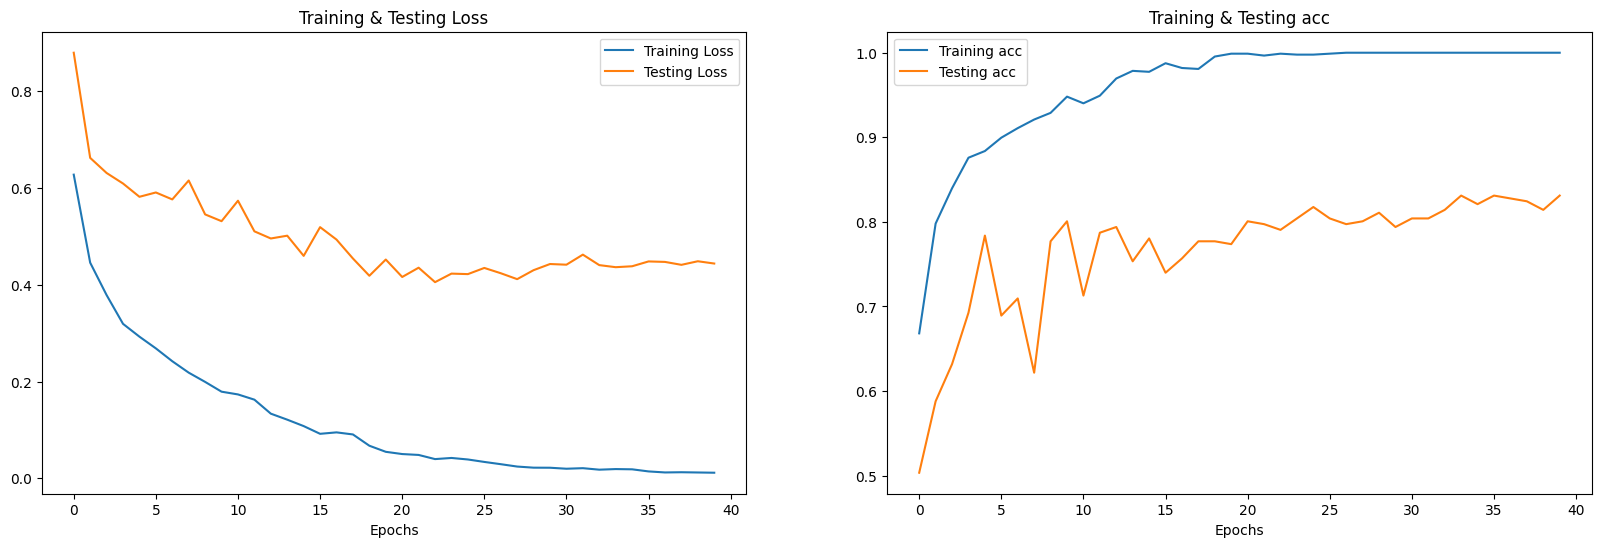

In [ ]:
check_accuracy(x_test_with_mfcc, y_test_with_mfcc, model_mfcc)

10/10 [==============================] - 0s 28ms/step - loss: 0.3510 - acc: 0.8750
Accuracy of our model on test data :  87.5 %


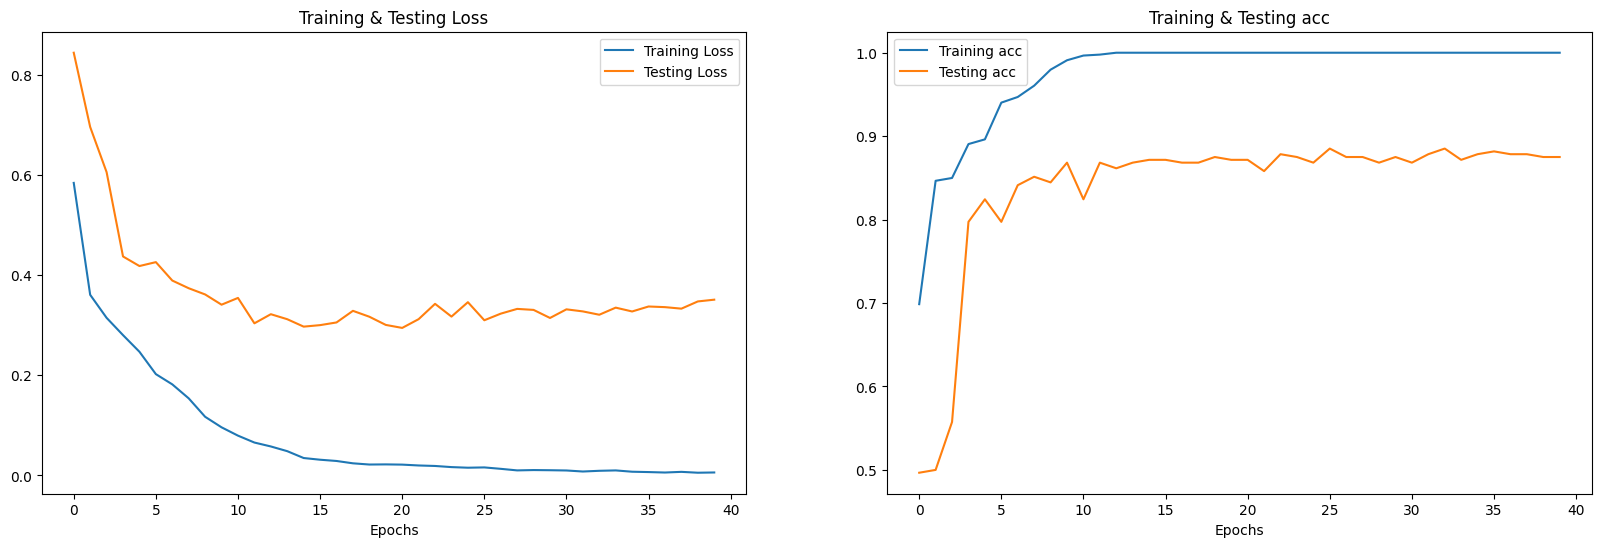

In [22]:
check_accuracy(x_test_with_spec, y_test_with_spec, model_spec)

check_accuracy(x_test_with_mfcc, y_test_with_mfcc)

In [27]:
import wave

predict_data_path = "/content/drive/MyDrive/Colab Notebooks/data/WAV2 High/hello2-angm2.wav"
predict_low_data_path = "/content/drive/MyDrive/Colab Notebooks/data/WAV2 Low/hot1-lm3.wav"

random_data_path = "/content/drive/MyDrive/Colab Notebooks/data/Random Data/output_ravdess_fear.wav"



y, sr = librosa.load(random_data_path, sr=24000)

# Resample to 8000 Hz
y_resampled = librosa.resample(y, orig_sr=sr, target_sr=8000)
output_path = "/content/drive/MyDrive/Colab Notebooks/data/Random Data/output.wav"
sf.write(output_path, y_resampled, 8000)

wav = wave.open(output_path)
print("Sampling (frame) rate = ", wav.getframerate())
print("Total samples (frames) = ", wav.getnframes())
print("Duration = ", wav.getnframes()/wav.getframerate())



predict_data = prepare_data2([output_path])
predict_data = model_spec.predict(predict_data, use_multiprocessing=True, workers=6, verbose=1)
predicted_labels = encoder.inverse_transform([np.argmax(predict_data)])

print(predict_data)
print(predicted_labels)
# encoder.fit(y_train)
# y_train = encoder.transform(y_train)

Sampling (frame) rate =  8000
Total samples (frames) =  17351
Duration =  2.168875


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step
[[0.9973883  0.00261173]]
['HighStress']


In [ ]:
model1= Sequential()
model1.add(Conv2D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(dim[0], dim[1], 2)))
model1.add(MaxPooling2D(pool_size=5, strides = 2, padding = 'same'))

model1.add(Conv2D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model1.add(MaxPooling2D(pool_size=5, strides = 2, padding = 'same'))

model1.add(Conv2D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model1.add(MaxPooling2D(pool_size=5, strides = 2, padding = 'same'))
model1.add(Dropout(0.2))

model1.add(Conv2D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model1.add(MaxPooling2D(pool_size=5, strides = 2, padding = 'same'))

model1.add(Flatten())
model1.add(Dense(units=64, activation='relu'))
model1.add(Dropout(0.2))

model1.add(Dense(units=32, activation='relu'))
model1.add(Dropout(0.3))

model1.add(Dense(units=2, activation='softmax'))
model1.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model1.summary()

In [ ]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0001)
history = model1.fit(X_train, Y_train,
                    validation_data=(X_test, Y_test),
                    batch_size=32,
                    callbacks=[rlrp],
                    epochs=40)

Epoch 1/40
28/28 [==============================] - 73s 3s/step - loss: 14.8199 - accuracy: 0.5023 - val_loss: 0.6899 - val_accuracy: 0.5946 - lr: 0.0010
Epoch 2/40
28/28 [==============================] - 53s 2s/step - loss: 0.6937 - accuracy: 0.5248 - val_loss: 0.6619 - val_accuracy: 0.6554 - lr: 0.0010
Epoch 3/40
28/28 [==============================] - 50s 2s/step - loss: 0.6184 - accuracy: 0.6614 - val_loss: 0.5513 - val_accuracy: 0.7635 - lr: 0.0010
Epoch 4/40
28/28 [==============================] - 56s 2s/step - loss: 0.6100 - accuracy: 0.6727 - val_loss: 0.5261 - val_accuracy: 0.7973 - lr: 0.0010
Epoch 5/40
28/28 [==============================] - 55s 2s/step - loss: 0.5671 - accuracy: 0.7178 - val_loss: 0.4879 - val_accuracy: 0.8108 - lr: 0.0010
Epoch 6/40
28/28 [==============================] - 54s 2s/step - loss: 0.5197 - accuracy: 0.7449 - val_loss: 0.4171 - val_accuracy: 0.8176 - lr: 0.0010
Epoch 7/40
28/28 [==============================] - 53s 2s/step - loss: 0.4859 - 

In [ ]:
import wave

predict_data_path = "/content/drive/MyDrive/Colab Notebooks/data/WAV2 High/hello2-angm2.wav"
predict_low_data_path = "/content/drive/MyDrive/Colab Notebooks/data/WAV2 Low/hot1-lm3.wav"

random_data_path = "/content/drive/MyDrive/Colab Notebooks/data/Random Data/output_ravdess_calm.wav"



y, sr = librosa.load(random_data_path, sr=24000)

# Resample to 8000 Hz
y_resampled = librosa.resample(y, orig_sr=sr, target_sr=8000)
output_path = "/content/drive/MyDrive/Colab Notebooks/data/Random Data/file_resampled.wav"
sf.write(output_path, y_resampled, 8000)

wav = wave.open(output_path)
print("Sampling (frame) rate = ", wav.getframerate())
print("Total samples (frames) = ", wav.getnframes())
print("Duration = ", wav.getnframes()/wav.getframerate())



predict_data = prepare_data2([output_path])
predict_data = model1.predict(predict_data, use_multiprocessing=True, workers=6, verbose=1)
predicted_labels = encoder.inverse_transform([np.argmax(predict_data)])

print(predict_data)
print(predicted_labels)
# encoder.fit(y_train)
# y_train = encoder.transform(y_train)

Sampling (frame) rate =  8000
Total samples (frames) =  28295
Duration =  3.536875


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step
[[0.9938811  0.00611895]]
['HighStress']


In [ ]:
AudioSPH = "/content/drive/MyDrive/Colab Notebooks/data/SPH High" #Disesuaikan untuk directory
AudioWAV = "/content/drive/MyDrive/Colab Notebooks/data/WAV2 High"

import soundfile as sf
import os

# Create the destination folder if it doesn't exist
if not os.path.exists(AudioWAV):
    os.makedirs(AudioWAV)

# Recursively search for .sph files in nested folders
for root, _, files in os.walk(AudioSPH):
  # print(files)
    for filename in files:
        if filename.endswith('.sph'):
            input_path = os.path.join(root, filename)

            # Get the relative path within the source folder
            rel_path = os.path.relpath(root, AudioSPH)

            # Create a folder name for the destination folder
            # dest_folder_name = rel_path.replace(os.path.sep, '-')

            output_filename = f'{os.path.splitext(filename)[0]}.wav'
            output_path = os.path.join(AudioWAV, output_filename)
            # print(output_path)
            # Convert SPH to WAV using soundfile
            sph_data, sample_rate = sf.read(input_path)
            sf.write(output_path, sph_data, sample_rate)

print("Conversion completed.")

Conversion completed.


Backend Zidane


In [ ]:
audio_length = 8000 * 1
dim_mfcc = (40, 1 + int(np.floor(audio_length / 512)), 1)
dim_spectral_centroid = (1, 1 + int(np.floor(audio_length / 512)), 1)

def prepare_data2(fnames):
    X_mfcc = []
    X_spectral_centroid = []

    input_length = audio_length

    for i, fname in tqdm_notebook(enumerate(fnames), total=len(fnames)):
        data, _ = librosa.core.load(fname, sr=8000, res_type="kaiser_fast")

        # Random offset / Padding
        if len(data) > input_length:
            max_offset = len(data) - input_length
            offset = np.random.randint(max_offset)
            data = data[offset:(input_length + offset)]
        else:
            if input_length > len(data):
                max_offset = input_length - len(data)
                offset = np.random.randint(max_offset)
            else:
                offset = 0
            data = np.pad(data, (offset, input_length - len(data) - offset), "constant")

        # Extract MFCCs
        mfccs = librosa.feature.mfcc(y=data, sr=8000, n_mfcc=40)
        mfccs = np.expand_dims(mfccs, axis=-1)
        X_mfcc.append(mfccs)

        # Extract Spectral Centroid
        spectral_centroid = librosa.feature.spectral_centroid(y=data, sr=8000)
        spectral_centroid = np.expand_dims(spectral_centroid, axis=-1)
        X_spectral_centroid.append(spectral_centroid)

    # Ensure the same time and frequency dimensions for both features
    max_time_dim = max(max(x.shape[1] for x in X_mfcc), max(x.shape[1] for x in X_spectral_centroid))
    max_freq_dim = max(X_mfcc[0].shape[0], X_spectral_centroid[0].shape[0])

    # Pad and reshape the features individually
    X_mfcc_padded = np.array([np.pad(x, ((0, max_freq_dim - x.shape[0]), (0, 0), (0, max_time_dim - x.shape[1])), mode='constant') for x in X_mfcc])
    X_spectral_centroid_padded = np.array([np.pad(x, ((0, max_freq_dim - x.shape[0]), (0, 0), (0, max_time_dim - x.shape[1])), mode='constant') for x in X_spectral_centroid])

    # Combine MFCCs and Spectral Centroid
    X_combined = np.concatenate([X_mfcc_padded, X_spectral_centroid_padded], axis=-1)

    return X_combined


In [ ]:
random_data_path = "FILE UPLOAD FROM USER"

y, sr = librosa.load(random_data_path, sr=24000)

# Resample to 8000 Hz
y_resampled = librosa.resample(y, orig_sr=sr, target_sr=8000)
output_path = "/file_resampled.wav"
sf.write(output_path, y_resampled, 8000)

# Predict and Data Classes
predict_data = prepare_data2([output_path])
predict_data = model1.predict(predict_data, use_multiprocessing=True, workers=6, verbose=1)
predicted_labels = encoder.inverse_transform([np.argmax(predict_data)])